<a href="https://colab.research.google.com/github/arsilva02/librarianproject/blob/main/WebScrapingAndFeatureGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering within the DF

In [6]:
import pandas as pd
df = pd.read_csv('data/storygraphExport.csv')
#df = pd.read_csv('data/scrapedDirty.csv')

In [ ]:
#lets look at the contributers section
df[~df['Contributors'].isna()]['Contributors']

,Contributors
12,Neil Smith (Translator)
15,Frances Riddle (Translator)
17,Lucy Scott (Translator)
20,Jeffrey Angles (Translator)
22,"Stephanie Ortega (Translator), Sophie Haydock ..."
...,...
700,"William Hutson (Contributor), Daveed Diggs (Co..."
712,Cassandra Medcalf (Narrator)
713,Gregory Rabassa (Translator)
714,Carol Brown Janeway


In [ ]:
#if a "translator" is found in the contributor section, i will mark it as translated
def translation(df):
    df['Translated'] = df['Contributors'].str.contains(r'\(Translator\)', na=False)
    return df

df = translation(df)

,Title,Authors,Contributors,ISBN/UID,Format,Read Status,Date Added,Last Date Read,Dates Read,Read Count,...,Review,Content Warnings,Content Warning Description,Tags,Owned?,pages,pub_year,tags,series,Translated
0,You've Lost a Lot of Blood,Eric LaRocca,NaN,9781088025758,paperback,to-read,2024/05/06,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,No,209.0,2022.0,"[fiction, horror, lgbtqia+, challenging, dark,...",False,False
1,Long After We Are Gone,Terah Shelton Harris,NaN,9781728265773,paperback,to-read,2024/09/06,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,Yes,412.0,2024.0,"[fiction, literary, emotional, reflective, sad...",False,False
2,Shuggie Bain,Douglas Stuart,NaN,9780802148049,hardcover,to-read,2024/08/27,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,No,448.0,2020.0,"[fiction, historical, lgbtqia+, literary, dark...",False,False
3,Helpmeet,Naben Ruthnum,NaN,9781988964386,paperback,to-read,2024/10/01,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,No,89.0,2022.0,"[fiction, horror, dark, mysterious, fast-paced]",False,False
4,Angelfall,Susan Ee,NaN,9780761463276,paperback,to-read,2024/04/01,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,No,284.0,2011.0,"[fiction, fantasy, young adult, adventurous, d...",True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,Eleanore of Avignon,Elizabeth DeLozier,NaN,9780593475034,hardcover,to-read,2024/09/23,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,No,320.0,2024.0,"[fiction, historical, emotional, sad, tense, m...",False,False
724,The Crane Husband,Kelly Barnhill,NaN,9781250850973,hardcover,to-read,2024/09/05,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,No,128.0,2023.0,"[fiction, fantasy, horror, dark, emotional, my...",False,False
725,Artificial Intelligence: An Illustrated Histor...,Clifford A. Pickover,NaN,9781454955788,paperback,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,240.0,2019.0,"[nonfiction, history, science, informative, me...",False,False
726,The Road,Cormac McCarthy,NaN,9780307265432,hardcover,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,241.0,2006.0,"[fiction, dystopian, literary, dark, emotional...",False,False


# Webscraping

Two book tracking sites will be scraped for this project to get the following data:

**Storygraph:**


*   genres/mood/pacing
*   if a book is in a series (as a boolean)
*   number of pages (if book is not an audiobook)
*   year of original publication

**Goodreads:**


*   book blurb
*   number of reviews




## StoryGraph Web Scraper

StoryGraph offers many different types of information on their website. Specifically, we can search by ISBN (or title + author(s) if no ISBN is available). Here is what a page for a specific book looks like on the website:
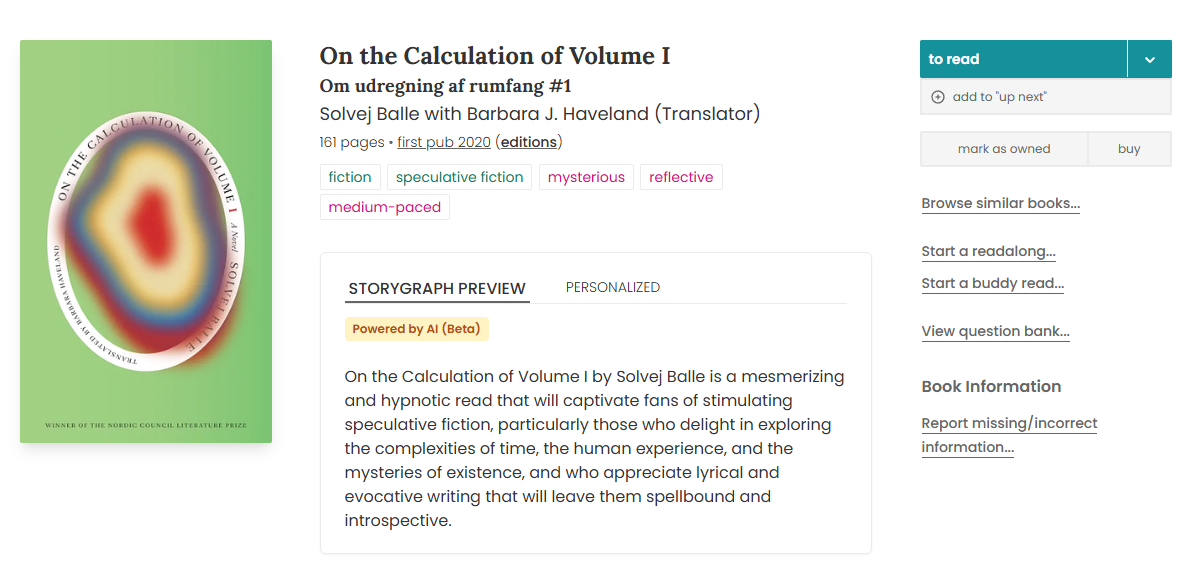

---

The important things I want to extract from this page are the number of pages (if the book is not an audio book) and the published year. There are also genre and mood tags, as seen in green in pink. I really like the way StoryGraph organizes these, which is why I wanted to take it from this website. Finally, as seen under the title of the book, is the series that the book belongs to (if the series is applicable, otherwise this header does not show up.)

I also want to take the blurb for each book and the number of reviews, but I will do that on another book tracking site- Goodreads. Goodreads tends to have the best blurbs (in my opinion) and is more popular, so the number of reviews should be a bit more universal since StoryGraph has more of a niche audience. I also wanted to use both BeautifulSoup and Selenium in this project, and it is pretty hard to extract that information from StoryGraph using BeautifulSoup, so we’ll save that information for the Goodreads scraper.


In [ ]:
pip install selenium

In [3]:
#imports (will be used as we go)
import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')  # Add the ChromeDriver path to the system path for execution.
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
import time

In [4]:
#like mentioned above, we are going to use BeautifulSoup to extract information from the Storygraph
import requests
from bs4 import BeautifulSoup
import math
import time
import re
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
#this function takes in your dataframe, then outputs that same dataframe with 3 new columns:
#published year (first published, not when a specific edition was published)
#number of pages (important to note that there are some audiobooks in this list, and those will be left blank. thats fine since im not a huge audiobook reader but this could be fixed)
#tags. these are things like genres (literary, fantasy, etc.) and moods/pacing (dark, mysterious, slow-paced)
def sg_scraper(df):

    master = 'app.thestorygraph.com' #site we are using
    search_master = '/browse?search_term=' #search url
    results = []  #we are using this to store results for each row

    # Create chrome instance and configure
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-blink-features=AutomationControlled')
    chrome_options.add_argument('user-agent=name')
    wd = webdriver.Chrome(options=chrome_options)

    wd.get('https://'+master+search_master)

    close_button = WebDriverWait(wd, 10).until(
            EC.element_to_be_clickable((By.ID, "close-cookies-popup"))
        )

        # Click the SVG element
    close_button.click()

    #iterate through each row
    for index, row in df.iterrows():
        title = row['Title']
        author = row['Authors'].replace(", ", " ")
        isbn = row['ISBN/UID']
        format = row['Format']
        data = {}

        if pd.isna(isbn):
            search = f"{title.replace(' ', '%20')}%20{author.replace(' ', '%20')}"
        else:
            search = isbn

        search_url = f"https://{master}{search_master}{search}"


        try:
            wd.get(search_url)

            book_link = wd.find_element(By.XPATH, "//h1[@class='font-bold text-xl']/a").get_attribute('href')


            wd.get(book_link)

            text = wd.find_element(By.XPATH,'/html/body/div[1]/div/main/div/div[3]/div/div[2]/p').text.strip()

            try:

                if format == 'audio':
                  audio_match = re.search(r'(\d+)\s*hours?,\s*(\d+)\s*minutes?', text)
                  hours = int(audio_match.group(1)) if audio_match else np.nan
                  minutes = int(audio_match.group(2)) if audio_match else np.nan
                  length = hours * 60 + minutes

                else:
                  pages_match = re.search(r"(\d+)\s+pages", text)
                  pages = int(pages_match.group(1)) if pages_match else np.nan
                  length = pages
                data['length'] = length

            except Exception as e:
                data['length'] = np.nan

            try:
                year_match = re.search(r"first pub (\d{4})", text)
                pub_year = int(year_match.group(1)) if year_match else float('nan')

                data['pub_year'] = pub_year

            except (AttributeError, ValueError):
                 data['pub_year'] = np.nan
            except Exception as e:
                data['pub_year'] = np.nan

            try:
                tags = wd.find_element(By.CLASS_NAME,"mt-2").text.split(' ')
                data['tags'] = tags
            except Exception as e:
                data['tags'] = []


            try:
              wd.find_element(By.XPATH,"/html/body/div[1]/div/main/div/div[4]/div[1]/div[2]/div[1]/h3/p[2]/a")
              series = True
            except:
              series = False

            data['series'] = series

            try:
              read_more_button = WebDriverWait(wd, 1).until(EC.element_to_be_clickable((By.CLASS_NAME, "read-more-btn")) )
              read_more_button.click()


            except:
              pass

            try:
              blurb = wd.find_elements(By.CLASS_NAME, "trix-content")[0].text

              data['blurb'] = blurb
            except Exception as e:
              data['blurb'] = np.nan


            try:
              reviews = WebDriverWait(wd, 60).until(
                  EC.presence_of_element_located((By.CLASS_NAME, "inverse-link"))
              ).text
              match = re.search(r'([\d,]+)\s*reviews?', reviews)
              review_count_str = int(match.group(1).replace(',', ''))
              data['reviews'] = review_count_str
            except Exception as e:
              data['reviews'] = np.nan

            try:
              star_rating = float(wd.find_element(By.CLASS_NAME,"average-star-rating").text)
              data['star_rating'] = star_rating
            except Exception as e:
              data['star_rating'] = np.nan




        except (requests.exceptions.RequestException, AttributeError, TypeError, KeyError) as e:
            print(f"Error processing {search_url}: {e}")
            data['length'], data['pub_year'], data['tags'], data['blurb'], data['reviews'], data['star_rating'] = np.nan,np.nan, [], np.nan, np.nan, np.nan
        except Exception as e:
            print(f"An unexpected error occurred(general): {e}")
            data['length'], data['pub_year'], data['tags'], data['blurb'], data['reviews'], data['star_rating'] = np.nan,np.nan, [], np.nan, np.nan, np.nan

        results.append(data)

    # Create new columns from the results
    df['length'] = [result.get('length', np.nan) for result in results]
    df['pub_year'] = [result.get('pub_year', np.nan) for result in results]
    df['tags'] = [result.get('tags', []) for result in results]
    df['series'] = [result.get('series', False) for result in results]
    df['blurb'] = [result.get('blurb', np.nan) for result in results]
    df['reviews'] = [result.get('reviews', np.nan) for result in results]
    df['star_rating'] = [result.get('star_rating', np.nan) for result in results]



    return df


In [ ]:
df = sg_scraper(df)

### Cleaning Blurbs

Some fields are empty, but this is a relatively low amount. We'll fill them in anyways using the correct ISBN.

Note that two of these are pretty niche with 1 or 2 reviews, and are old/indie so there aren't any descriptions to be found.

In [30]:
df.loc[86,'blurb'] = """
For the bicentennial of its first publication, Mary Shelley's original 1818 text, introduced by National Book Critics Circle award-winner Charlotte Gordon. Nominated as one of America's best-loved novels by PBS's The Great American Read
 2018 marks the bicentennial of Mary Shelley's seminal novel. For the first time, Penguin Classics will publish the original 1818 text, which preserves the hard-hitting and politically-charged aspects of Shelley's original writing, as well as her unflinching wit and strong female voice. This edition also emphasizes Shelley's relationship with her mother--trailblazing feminist Mary Wollstonecraft, who penned A Vindication of the Rights of Woman--and demonstrates her commitment to carrying forward her mother's ideals, placing her in the context of a feminist legacy rather than the sole female in the company of male poets, including Percy Shelley and Lord Byron.
 This edition includes a new introduction and suggestions for further reading by National Book Critics Circle award-winner and Shelley expert Charlotte Gordon, literary excerpts and reviews selected by Gordon, and a chronology and essay by preeminent Shelley scholar Charles E. Robinson.
 For more than seventy years, Penguin has been the leading publisher of classic literature in the English-speaking world. With more than 1,800 titles, Penguin Classics represents a global bookshelf of the best works throughout history and across genres and disciplines. Readers trust the series to provide authoritative texts enhanced by introductions and notes by distinguished scholars and contemporary authors, as well as up-to-date translations by award-winning translators.
 """

df.loc[420,'blurb'] = """
 Imajica is an epic beyond compare: vast in conception, obsessively detailed in execution, and apocalyptic in its resolution. At its heart lies the sensualist and master art forger, Gentle, whose life unravels when he encounters Judith Odell, whose power to influence the destinies of men is vaster than she knows, and Pie 'oh' pah, an alien assassin who comes from a hidden dimension.

That dimension is one of five in the great system called Imajica. They are worlds that are utterly unlike our own, but are ruled, peopled, and haunted by species whose lives are intricately connected with ours. As Gentle, Judith, and Pie 'oh' pah travel the Imajica, they uncover a trail of crimes and intimate betrayals, leading them to a revelation so startling that it changes reality forever.
"""

df.loc[501,'blurb'] = """
"A modern classic of courage and excitement." --The New Yorker

Soon to be a Major Motion Picture Starring Charlie Hunnam and Rami Malek

Henri Charri re, nicknamed Papillon, for the butterfly tattoo on his chest, was convicted in Paris in 1931 of a murder he did not commit. Sentenced to life imprisonment in the penal colony of French Guiana, he became obsessed with one goal: escape. After planning and executing a series of treacherous yet failed attempts over many years, he was eventually sent to the notorious prison, Devil's Island, a place from which no one had ever escaped . . . until Papillon. His flight to freedom remains one of the most incredible feats of human cunning, will, and endurance ever undertaken.

Charri re's astonishing autobiography, Papillon, was first published in France to instant acclaim in 1968, more than twenty years after his final escape. Since then, it has become a treasured classic--the gripping, shocking, ultimately uplifting odyssey of an innocent man who would not be defeated.

"A first-class adventure story." -- New York Review of Books
"""


In [31]:
df[df['blurb'].isna()]

,Title,Authors,Contributors,ISBN/UID,Format,Read Status,Date Added,Last Date Read,Dates Read,Read Count,...,Content Warning Description,Tags,Owned?,length,pub_year,tags,series,blurb,reviews,star_rating
175,For The Better,Daniel J. Volpe,NaN,2370001835825,hardcover,to-read,2024/06/12,NaN,NaN,0.0,...,NaN,NaN,No,161.0,2024.0,"[fiction, horror]",False,NaN,NaN,4.0
576,"The Four Major Cults: Christian Science, Jehov...",Anthony A. Hoekema,NaN,9780802804457,paperback,to-read,2024/11/28,NaN,NaN,0.0,...,NaN,NaN,No,464.0,1963.0,"[nonfiction, religion, informative, medium-paced]",False,NaN,NaN,4.0


### Cleaning Reviews

We'll do the same for reviews here.

In [40]:
df.loc[7,'reviews'] = 103
df.loc[22,'reviews'] = 4
df.loc[86,'reviews'] = 158197
df.loc[175,'reviews'] = 3
df.loc[226,'reviews'] = 802
df.loc[244,'reviews'] = 1
df.loc[263,'reviews'] = 397034
df.loc[328,'reviews'] = 83
df.loc[420,'reviews'] = 336
df.loc[448,'reviews'] = 3
df.loc[498,'reviews'] = 239
df.loc[501,'reviews'] = 2740
df.loc[547,'reviews'] = 66
df.loc[555,'reviews'] = 52
df.loc[576,'reviews'] = 1
df.loc[594,'reviews'] = 7
df.loc[600,'reviews'] = 174



### Cleaning Star Rating
Finally, we will clean the star rating.

In [43]:
df.loc[7,'star_rating'] = 3.63
df.loc[22,'star_rating'] = 5
df.loc[86,'star_rating'] = 3.85
df.loc[226,'star_rating'] = 3.92
df.loc[263,'star_rating'] = 4.0
df.loc[328,'star_rating'] = 3.21
df.loc[498,'star_rating'] = 3.29
df.loc[555,'star_rating'] = 3.66




## Goodreads Web Scraper

In [ ]:
# Create chrome instance and configure
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-blink-features=AutomationControlled')
chrome_options.add_argument('user-agent=name')
wd = webdriver.Chrome(options=chrome_options)


In [ ]:
def gr_scraper(df):
  i = 0
  master = 'https://goodreads.com'
  search_master = '/search'
  element_locator = (By.ID, "search_query_main")
  results = []  # Store results for each row

  for index, row in df.iterrows():
      i += 1
      title = row['Title']
      author = row['Authors'].replace(", ", " ")
      isbn = row['ISBN/UID']
      format = row['Format']
      data = {}

      if pd.isna(isbn) or format == 'audio':
          search = title + " " + author
      else:
          search = isbn
      print(i)

      try:
          wd.get(master+search_master)
          search_bar = wd.find_element(By.ID, "search_query_main")
          try:
                      button = wd.find_element(By.XPATH, "/html/body/div[3]/div/div/div[1]/button")
                      button.click()
          except Exception as e:
                pass

          search_bar.clear()
          search_bar.send_keys(search)

          search_button = wd.find_element(By.CSS_SELECTOR, "input.searchBox__button")

          try:
                  button = wd.find_element(By.XPATH, "/html/body/div[3]/div/div/div[1]/button")
                  button.click()
                  print("Close button clicked successfully.")
          except Exception as e:
            pass

          search_button.click()

          try:
            link = wd.find_element(By.CSS_SELECTOR, "a.bookTitle")
            link.click()
          except Exception as e:
            pass
          try:
            blurb = wd.find_elements(By.CSS_SELECTOR, "span.Formatted")[0].text
            ratings = wd.find_element(By.XPATH,"/html/body/div[1]/div[2]/main/div[1]/div[2]/div[2]/div[2]/div[2]/a/div[2]/div/span[1]").text
            ratings = int(re.sub(r"[^\d]", "", ratings))

            data['blurb'] = blurb
            data['ratings'] = ratings
          except Exception as e:
            print('Error occured', e)
            print('Error on blurb/ratings')
            data['blurb'], data['ratings'] = float('nan'), float('nan')
      except Exception as e:
        print('Error occured', e)


      results.append(data)

    # Create new columns from the results
  df['blurb'] = [result.get('blurb', float('nan')) for result in results]
  df['ratings'] = [result.get('ratings', float('nan')) for result in results]

  return df

In [ ]:
df = gr_scraper(df)


# Publisher API

In [48]:
import time


In [49]:
def get_publisher_openlibrary(df):
    """
    Retrieves the publisher for each book in a DataFrame using the Open Library API.
    Handles invalid ISBNs and API errors.
    """

    def get_publisher(isbn=None):
        """Helper function to get publisher for a single book."""
        if not isbn or pd.isna(isbn):
            return np.nan

        base_url = f"https://openlibrary.org/isbn/{isbn}.json"


        try:
            response = requests.get(base_url)
            response.raise_for_status()

            try:
                data = response.json()
            except ValueError:
                return "Invalid API response"

            if isinstance(data.get("publishers"), list):
                publishers = []
                for publisher in data["publishers"]:
                    if isinstance(publisher, dict) and "name" in publisher:
                        publishers.append(publisher["name"])
                    elif isinstance(publisher, str): #handle the case where publishers is a list of strings.
                      publishers.append(publisher)
                return ", ".join(publishers) if publishers else "Publisher not found"
            else:
                return np.nan

        except requests.exceptions.RequestException as e:
            return np.nan

    publishers = []
    for index, row in df.iterrows():
        isbn = row.get('ISBN/UID')
        publisher = get_publisher(isbn=isbn)
        publishers.append(publisher)
        time.sleep(.5)

    df['publisher'] = publishers
    return df



In [50]:
df = get_publisher_openlibrary(df)

# Theme extraction

In [ ]:
pip install langchain_openai

In [ ]:
openaikey = "OPENAIKEYHERE"

In [ ]:
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

def extract_themes_openai(df, blurb_col="blurb", genres_col="tags", openai_api_key=openaikey, model_name="gpt-4o-mini"):


    template = f"""
        You are a literary analyst. Extract the main themes from the following book blurb.
        Make sure to avoid niche or very specific themes. If themes are related, consolidate them into broader themes.
        You can have as many themes as you like, but again keep them pretty general. I would rather have too many themes than not enough. Each theme should not be more than 4 words long.
        Return the themes as a comma-separated list (no other text).

        your output should look like this (of course, replace with relevant themes):

        motherhood, power vs. control, lesbian relationship, romance, friendship, trauma, grief, abstract


        here is information about the book:
        tags (genres and moods and pace): {{genres}}

        Blurb:
        {{blurb}}

        Themes:
        """

    prompt = ChatPromptTemplate.from_template(template)
    model = ChatOpenAI(openai_api_key=openai_api_key, model=model_name)
    chain = prompt | model

    def get_themes(blurb, genres):
        if not blurb or pd.isna(blurb):
            return None

        try:
            response = chain.invoke({"blurb": blurb, "genres": ", ".join(genres)})
            themes = [theme.strip() for theme in response.content.strip().split(',')]
            return themes
        except Exception as e:
            print(f"Error extracting themes: {e}")
            return None

    df['themes'] = df.apply(lambda row: get_themes(row[blurb_col], row[genres_col]), axis=1)
    return df

df = extract_themes_openai(df, openai_api_key=openaikey)


In [ ]:
df[:9]['themes'].values

array([list(['terror', 'loss', 'sacrifice', 'memory', 'danger', 'darkness', 'survival', 'horror', 'obsession', 'relationships']),
       list(['family dynamics', 'personal struggle', 'secrets and lies', 'loss and grief', 'legacy and inheritance', 'emotional conflict', 'self-discovery', 'societal pressures', 'resilience', 'redemption']),
       list(['addiction', 'family dynamics', 'childhood struggle', 'poverty', 'pursuit of happiness', 'identity', 'societal issues', 'love and support', 'resilience', 'loneliness']),
       list(['transformation', 'mortality', 'love', 'mystery', 'sacrifice', 'the unknown', 'journey', 'resilience', 'isolation']),
       list(['sisterhood', 'survival', 'redemption', 'sacrifice', 'good vs. evil', 'fear', 'loyalty', 'adventure', 'empowerment']),
       list(["women's sexuality", 'self-acceptance', 'confidence', 'contextual influences', 'personal empowerment', 'health education', 'body image', 'research and science', 'intimacy', 'joy']),
       list(['self-d

In [47]:

df.to_csv('scrapedDirty.csv', index=False)

print("CSV file saved successfully!")

CSV file saved successfully!
